<a href="https://colab.research.google.com/github/COMP90054/2024-S2-tutorials/blob/main/solution_set_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP90054 AI Planning for Autonomy
### Problem Set 06 - Relaxed Plan Heuristics ($h^\text{ff}$) and Iterated Width ($\textit{IW}$)


*Note- It is best to run this notebook on Colab(which runs an instance of linux), as the library requirements have been tested. As of now, we are aware of the issue that the `LAPKT`, Lighweight Automated Planning Toolkit, doesn't work on `macos`.*

*Note- The following exercises would require use of pen and paper to keep track of steps in the algorithms. The inputs fields inside the code blocks are there to help you validate your work.*

## Key takeaways
- Understand the motivation for Relaxed Plan Heuristics
- How to use $h^{add}$, $h^{max}$ computation to calculate $h^\text{ff
}$
- Understand how to apply Iterative Width to find a plan. Understand its properties, and pros-and-cons.

# Prepare the environment

In [ ]:
!pip install lapkt==0.1.1
!pip install func-timeout

from IPython.display import Latex, HTML
from func_timeout import func_timeout
from pandas import DataFrame, to_numeric
from numpy import inf
from lapkt.pddl.tarski import ground_generate_task as process_pddl
from lapkt.core.lib.wrapper import STRIPS_Interface, Fwd_Search_Problem, H_Add, H_Max
from functools import partial

import ipywidgets as widgets

# Four Action BlocksWorld
fluent_names = [
"clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"
]

# Four Action BlocksWorld PDDL
four_action_domain="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 4 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (domain BLOCKS)
  (:requirements :strips)
  (:predicates (on ?x ?y)
	       (ontable ?x)
	       (clear ?x)
	       (handempty)
	       (holding ?x)
	       )

  (:action pick-up
	     :parameters (?x)
	     :precondition (and (clear ?x) (ontable ?x) (handempty))
	     :effect
	     (and (not (ontable ?x))
		   (not (clear ?x))
		   (not (handempty))
		   (holding ?x)))

  (:action put-down
	     :parameters (?x)
	     :precondition (holding ?x)
	     :effect
	     (and (not (holding ?x))
		   (clear ?x)
		   (handempty)
		   (ontable ?x)))
  (:action stack
	     :parameters (?x ?y)
	     :precondition (and (holding ?x) (clear ?y))
	     :effect
	     (and (not (holding ?x))
		   (not (clear ?y))
		   (clear ?x)
		   (handempty)
		   (on ?x ?y)))
  (:action unstack
	     :parameters (?x ?y)
	     :precondition (and (on ?x ?y) (clear ?x) (handempty))
	     :effect
	     (and (holding ?x)
		   (clear ?y)
		   (not (clear ?x))
		   (not (handempty))
		   (not (on ?x ?y)))))

"""

four_action_problem="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 4 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (problem BLOCKS-example)
(:domain BLOCKS)
(:objects A B C)
(:INIT (CLEAR A) (CLEAR B) (ONTABLE B) (ONTABLE C) (ON A C) (HANDEMPTY))
(:goal (AND (ON A B) (ON B C)))
)
"""

# Create the PDDL domain file
with open("blocks_domain.pddl", 'w') as file:
  file.write(four_action_domain)

# Create the PDDL problem file
with open("blocks_problem.pddl", 'w') as file:
  file.write(four_action_problem)

four_action_blocks_problem = STRIPS_Interface("blocks_domain.pddl", "blocks_problem.pddl")

process_pddl("blocks_domain.pddl", "blocks_problem.pddl", four_action_blocks_problem)


# Two Action BlocksWorld PDDL

two_action_domain="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 2 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (domain BLOCKS)
  (:requirements :strips)
  (:predicates (on ?x ?y)
	       (ontable ?x)
	       (clear ?x)
	       )

  (:action move-to-block
	     :parameters (?x ?to)
	     :precondition (and (clear ?x) (ontable ?x) (clear ?to))
	     :effect
	     (and
		      (on ?x ?to)
	          (not (ontable ?x))
		      (not (clear ?to))

		 )
  )

 (:action move-to-table
	     :parameters (?x ?from)
	     :precondition (and (clear ?x) (on ?x ?from) )
	     :effect
	     (and (not (on ?x ?from))
		      (clear ?from)
		      (ontable ?x)
		 )
  )
)
"""

two_action_problem="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 2 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (problem BLOCKS-example)
(:domain BLOCKS)
(:objects A B C)
(:INIT (CLEAR A) (CLEAR B) (ONTABLE B) (ONTABLE C) (ON A C) )
(:goal (AND (ON A B) (ON B C)))
)
"""

# Create the PDDL domain file
with open("two_action_blocks_domain.pddl", 'w') as file:
  file.write(two_action_domain)

# Create the PDDL problem file
with open("two_action_blocks_problem.pddl", 'w') as file:
  file.write(two_action_problem)

two_action_blocks_problem = STRIPS_Interface("two_action_blocks_domain.pddl",
                                 "two_action_blocks_problem.pddl")

process_pddl("two_action_blocks_domain.pddl",
             "two_action_blocks_problem.pddl", two_action_blocks_problem)

pre_4_blocks = {
'start' : {},
'(pick-up a)': {'clear(a)', 'ontable(a)', 'handempty()'},
'(pick-up b)': {'clear(b)', 'ontable(b)', 'handempty()'},
'(pick-up c)': {'clear(c)', 'ontable(c)', 'handempty()'},
'(put-down a)': {'holding(a)'},
'(put-down b)': {'holding(b)'},
'(put-down c)': {'holding(c)'},
'(stack a a)': {'holding(a)', 'clear(a)'},
'(stack a b)': {'holding(a)', 'clear(b)'},
'(stack a c)': {'holding(a)', 'clear(c)'},
'(stack b a)': {'holding(b)', 'clear(a)'},
'(stack b b)': {'holding(b)', 'clear(b)'},
'(stack b c)': {'holding(b)', 'clear(c)'},
'(stack c a)': {'holding(c)', 'clear(a)'},
'(stack c b)': {'holding(c)', 'clear(b)'},
'(stack c c)': {'holding(c)', 'clear(c)'},
'(unstack a a)': {'on(a,a)', 'clear(a)', 'handempty()'},
'(unstack a b)': {'on(a,b)', 'clear(a)', 'handempty()'},
'(unstack a c)': {'on(a,c)', 'clear(a)', 'handempty()'},
'(unstack b a)': {'on(b,a)', 'clear(b)', 'handempty()'},
'(unstack b b)': {'on(b,b)', 'clear(b)', 'handempty()'},
'(unstack b c)': {'on(b,c)', 'clear(b)', 'handempty()'},
'(unstack c a)': {'on(c,a)', 'clear(c)', 'handempty()'},
'(unstack c b)': {'on(c,b)', 'clear(c)', 'handempty()'},
'(unstack c c)': {'on(c,c)', 'clear(c)', 'handempty()'},
}

UNIT_COST = 1

def validate_hff(problem, best_supp, relaxed_plan, goal, init, heuristic, b=None) -> bool :
    """
    Validates h_add and h_max best supporters
    Parameters -
        problem : STRIPS instance
        best_supp : manually computed bs function
    """
    assert(heuristic in ["h_add", "h_max"])

    if(heuristic=="h_add"):
        print("VALIDATING H_FF COMPUTATION USING H_ADD bs function\n")
        h = H_Add(problem)
    elif(heuristic=="h_max"):
        print("VALIDATING H_FF COMPUTATION USING H_MAX bs function \n")
        h = H_Max(problem)
    else:
        raise ValueError("Incorrect heuristic type")

    h.compute_init_h()

    bs = dict()
    h.fetch_best_supporters(bs)
    df = DataFrame([bs])

		# Alorithm to compute the relaxed plan given the best supporters
    open_set = goal - init
    closed = set()
    rp = set()

    while(len(open_set)>0):
        g = open_set.pop()
        closed.add(g)
        rp.add(df.loc[0][g])
        open_set.update(pre_4_blocks[df.loc[0][g]] - init.union(closed))

    if best_supp.loc[len(best_supp)-1].equals(df.loc[len(df)-1]):
        print("Best Supporter function is CORRECT :)\n")
    else:
        print("Best Supporter function is INCORRECT :(")

    if rp==relaxed_plan:
        print("Relaxed Plan is CORRECT :)\n")
    else:
        print("Relaxed Plan is INCORRECT :(")

***Started - reading and parsing pddl file ...***
***Finished reading and parsing pddl file after 0.106 seconds wall-clock time, 0.099 seconds CPU time***

***Started - preprocessing tarski problem ...***
***Finished preprocessing tarski problem after 0.002 seconds wall-clock time, 0.002 seconds CPU time***

***Started - grounding ...***
Total number of reachable action params =  24
***Finished grounding after 0.127 seconds wall-clock time, 0.019 seconds CPU time***

***Started - instantiating ...***
***Finished instantiating after 0.006 seconds wall-clock time, 0.003 seconds CPU time***

***Started - reading and parsing pddl file ...***
***Finished reading and parsing pddl file after 0.034 seconds wall-clock time, 0.031 seconds CPU time***

***Started - preprocessing tarski problem ...***
***Finished preprocessing tarski problem after 0.004 seconds wall-clock time, 0.002 seconds CPU time***

***Started - grounding ...***
Total number of reachable action params =  18
***Finished ground

# Problem 1. Relaxed Plan Heuristics

In a blocks-world problem, the agent’s aim is to stack the blocks as in the below figure

Blocksworld Diagramatic Representation
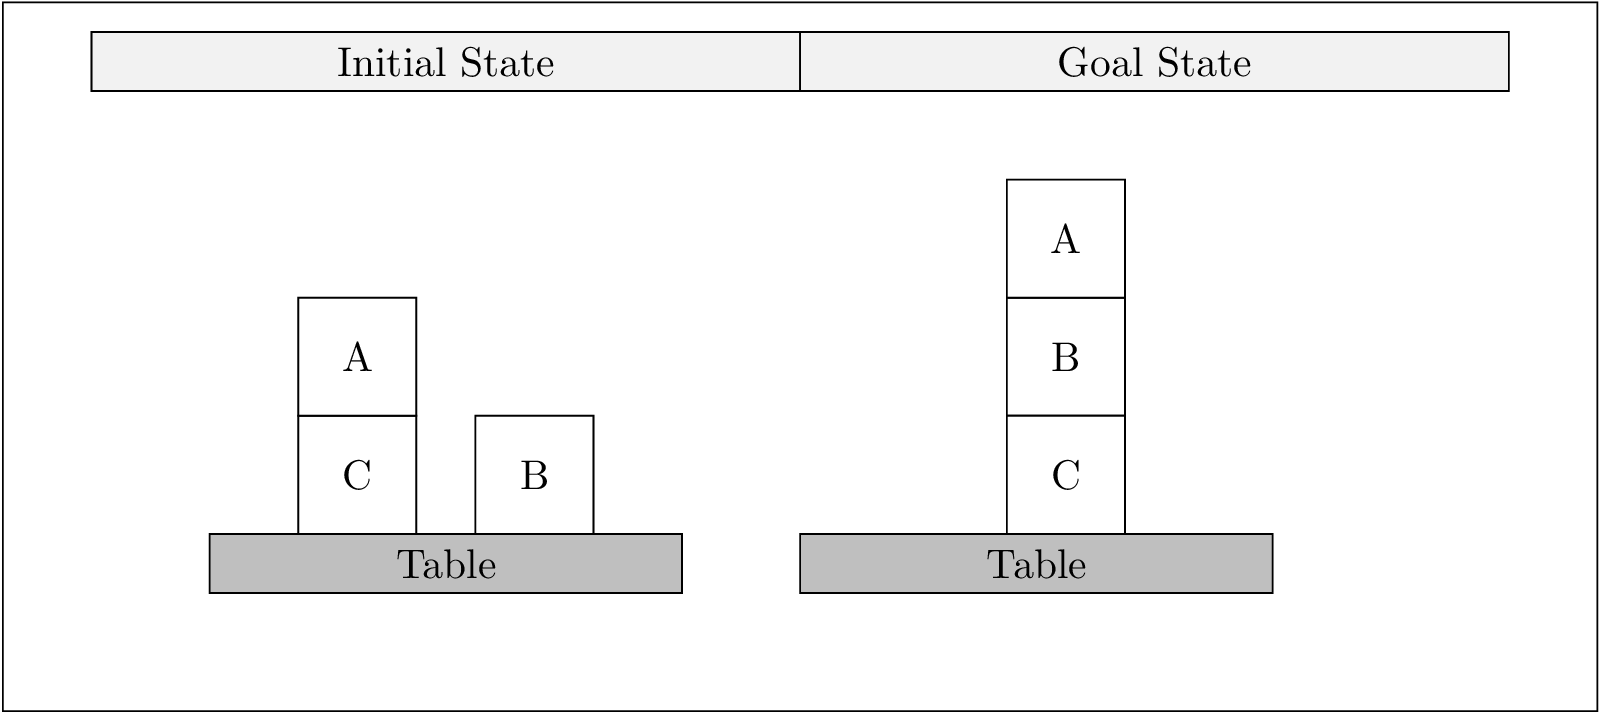

There are several important classes of domain-independent heuristics. Recall the delete relaxation based heuristics from Lectures.

We can compute $h^{add}$ and $h^{max}$ for the above Blocksworld problem.

### Task 1. Describe the init and goal set.

Instructions are within the triple-quotes.


In [ ]:
# Fluent Names
# ["clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"]

# INPUT REQUIRED
"""
Input the initial state
NOTE : Exact match with the fluent_names values is necessary
Example : init = {"clear(a)",  "clear(b)"}
"""
init = {"clear(a)", "clear(b)", "ontable(b)", "ontable(c)", "on(a,c)", "handempty()"}

# INPUT REQUIRED
"""
Input the goal set
NOTE : Exact match with the fluent_names values is necessary
Example : goal = {"clear(a)",  "clear(b)"}
"""
goal = {"on(a,b)",  "on(b,c)"}

### Task 2. Compute $h^\text{ff}(s_0)$ for the 4 operators blocks-world problem.

##### 1. Use $h^{max}$ for the best-supporters function

In [ ]:
h_max_bs = DataFrame(columns = fluent_names)

# INPUT REQUIRED
"""
Input the names of best supporters (actions) of each fluents, use 'NA' when the initial state supports a fluent
Operator set = {'(pick-up a)','(pick-up b)','(pick-up c)',
                '(put-down a)','(put-down b)','(put-down c)',
                '(stack a a)','(stack a b)','(stack a c)','(stack b a)','(stack b b)','(stack b c)','(stack c a)','(stack c b)','(stack c c)',
                '(unstack a a)','(unstack a b)','(unstack a c)','(unstack b a)','(unstack b b)','(unstack b c)','(unstack c a)','(unstack c b)','(unstack c c)'}
Example:
h_max_bs.loc[0] = ['NA', 'NA', '(unstack a c)', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

NOTE - Specify 'NA' if h_max(s, g) <= 0 or h_max(s, g)==inf
"""
# Column Headings (ordered)
# ["clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"]
h_max_bs.loc[0] = ['NA', 'NA', '(unstack a c)', 'NA' , '(unstack a c)', '(pick-up b)', '(pick-up c)', '(stack a a)', '(stack a b)', 'NA', '(stack b a)', '(stack b b)', '(stack b c)', '(stack c a)', '(stack c b)', '(stack c c)', '(put-down a)', 'NA', 'NA']

# Display the best supporters
display(h_max_bs)
print()
# h_max_bs = h_max_bs.mask(h_max_bs.astype(str).eq('NA')).dropna(axis=1, how='all')

# INPUT REQUIRED
"""
Use the pseudocode from lectures to compute the relaxed plan using the
best supporters which you computed above.
Example:
relaxed_plan = {(pick-up a)','(pick-up b)','(pick-up c)'}
"""

# Alorithm to compute the relaxed plan given the best supporters
open_set = goal - init
closed = set()
relaxed_plan_max = set()

while(len(open_set)>0):
  g = open_set.pop()
  closed.add(g)
  relaxed_plan_max.add(h_max_bs.loc[0][g])
  open_set.update(pre_4_blocks[h_max_bs.loc[0][g]] - init.union(closed))

print("Relaxed plan is:", relaxed_plan_max, "\n")
print("h_ff(s_0) =", sum([UNIT_COST for a in relaxed_plan_max]))

,clear(a),clear(b),clear(c),handempty(),holding(a),holding(b),holding(c),"on(a,a)","on(a,b)","on(a,c)","on(b,a)","on(b,b)","on(b,c)","on(c,a)","on(c,b)","on(c,c)",ontable(a),ontable(b),ontable(c)
0,NA,NA,(unstack a c),NA,(unstack a c),(pick-up b),(pick-up c),(stack a a),(stack a b),NA,(stack b a),(stack b b),(stack b c),(stack c a),(stack c b),(stack c c),(put-down a),NA,NA



Relaxed plan is: {'(unstack a c)', '(stack b c)', '(pick-up b)', '(stack a b)'} 

h_ff(s_0) = 4


###### Validate your best supporter function

In [ ]:
# Renders the button to validate solution
btn_h_max = widgets.Button(description='Click to validate', icon='check')
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
btn_h_max.on_click(partial(validate_hff, four_action_blocks_problem, h_max_bs, relaxed_plan_max, goal, init, "h_max"))
btn_h_max

Button(description='Click to validate', icon='check', style=ButtonStyle())

VALIDATING H_FF COMPUTATION USING H_MAX bs function 

Best Supporter function is CORRECT :)

Relaxed Plan is CORRECT :)



##### 2. Use $h^{add}$ for the best-supporters function

In [ ]:
h_add_bs = DataFrame(columns = fluent_names)

# INPUT REQUIRED
"""
Input the names of best supporters (actions) of each fluents, use 'NA' when the initial state supports a fluent
Operator set = {'(pick-up a)','(pick-up b)','(pick-up c)',
                '(put-down a)','(put-down b)','(put-down c)',
                '(stack a a)','(stack a b)','(stack a c)','(stack b a)','(stack b b)','(stack b c)','(stack c a)','(stack c b)','(stack c c)',
                '(unstack a a)','(unstack a b)','(unstack a c)','(unstack b a)','(unstack b b)','(unstack b c)','(unstack c a)','(unstack c b)','(unstack c c)'}
Example:
h_add_bs.loc[0] = ['NA', 'NA', '(unstack a c)', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

NOTE - Specify 'NA' if h_add(s, g) <= 0 or h_add(s, g)==inf
"""
# Column Headings (ordered)
# ["clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"]
h_add_bs.loc[0] = ['NA', 'NA', '(unstack a c)', 'NA' , '(unstack a c)', '(pick-up b)', '(pick-up c)', '(stack a a)', '(stack a b)', 'NA', '(stack b a)', '(stack b b)', '(stack b c)', '(stack c a)', '(stack c b)', '(stack c c)', '(put-down a)', 'NA', 'NA']

# Display the best supporters
display(h_add_bs)
print()

# INPUT REQUIRED
"""
Use the pseudocode from lectures to compute the relaxed plan using the
best supporters which you computed above.
Example:
relaxed_plan = {(pick-up a)','(pick-up b)','(pick-up c)'}
"""

# Alorithm to compute the relaxed plan given the best supporters
open_set = goal - init
closed = set()
relaxed_plan_add = set()

while(len(open_set)>0):
  g = open_set.pop()
  closed.add(g)
  relaxed_plan_add.add(h_add_bs.loc[0][g])
  open_set.update(pre_4_blocks[h_max_bs.loc[0][g]] - init.union(closed))

print("Relaxed plan is:", relaxed_plan_add, "\n")
print("h_ff(s_0) =", sum([UNIT_COST for a in relaxed_plan_add]))

,clear(a),clear(b),clear(c),handempty(),holding(a),holding(b),holding(c),"on(a,a)","on(a,b)","on(a,c)","on(b,a)","on(b,b)","on(b,c)","on(c,a)","on(c,b)","on(c,c)",ontable(a),ontable(b),ontable(c)
0,NA,NA,(unstack a c),NA,(unstack a c),(pick-up b),(pick-up c),(stack a a),(stack a b),NA,(stack b a),(stack b b),(stack b c),(stack c a),(stack c b),(stack c c),(put-down a),NA,NA



Relaxed plan is: {'(unstack a c)', '(stack b c)', '(pick-up b)', '(stack a b)'} 

h_ff(s_0) = 4


###### Validate your best supporter function

In [ ]:
# Renders the button to validate solution
btn_h_add = widgets.Button(description='Click to validate', icon='check')
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
btn_h_add.on_click(partial(validate_hff, four_action_blocks_problem, h_add_bs, relaxed_plan_add, goal, init, "h_add"))
btn_h_add

Button(description='Click to validate', icon='check', style=ButtonStyle())

VALIDATING H_FF COMPUTATION USING H_ADD bs function

Best Supporter function is CORRECT :)

Relaxed Plan is CORRECT :)



# Problem 2. Iterated Width ($\textit{IW}$)

Given the Blocks-World domain, with the $\textit{initial}$ state where blocks $A$, $B$, and $C$ are on the table,
and $\textit{goal}$ $A$ on $B$

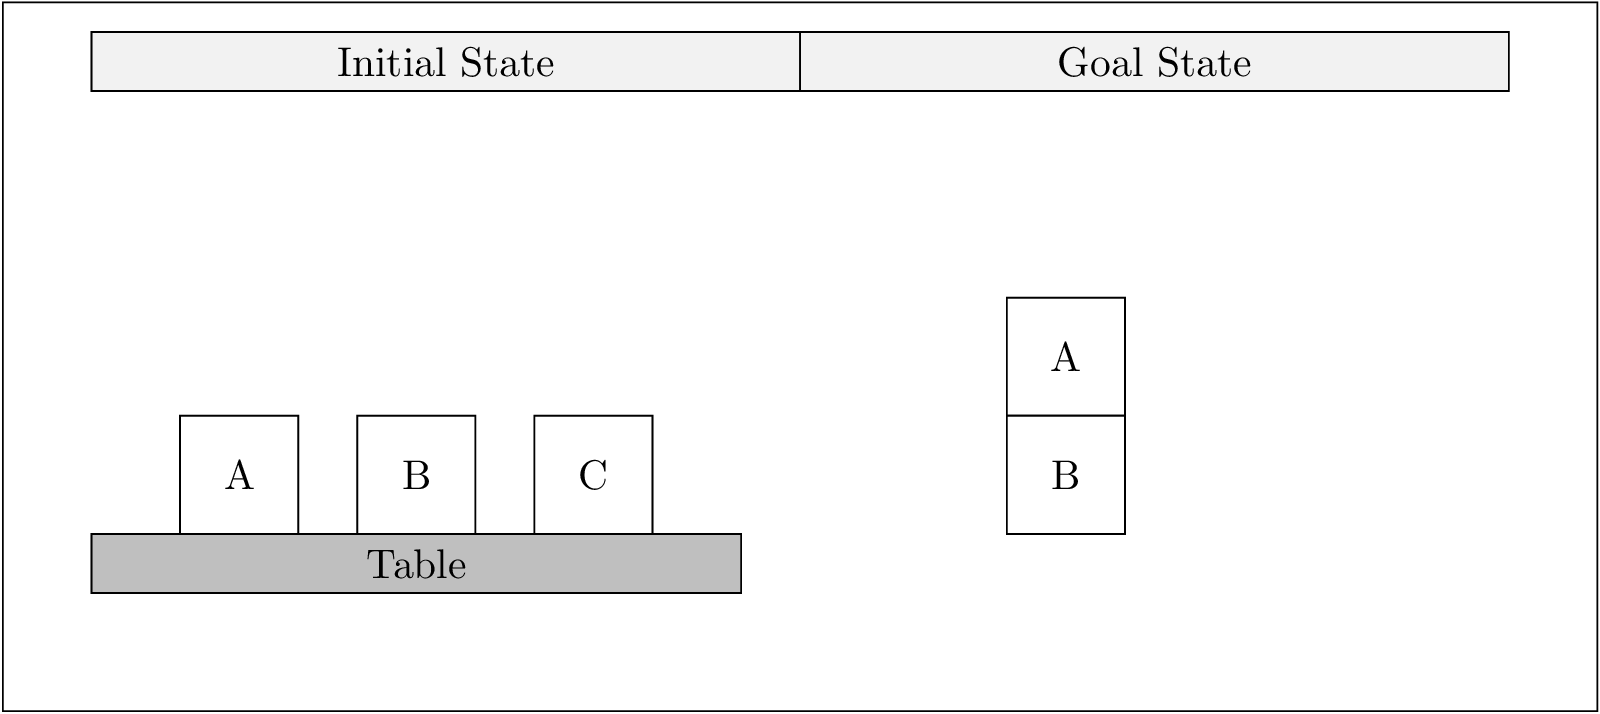

### Task. 1

Show the $\textit{IW(1)}$ search tree for this problem, highlighting each state why it passes the novelty pruning test or why is it being pruned. $\textit{IW(1)}$ should solve this problem. Stop as soon as you find a state that satisfies the goal condition.

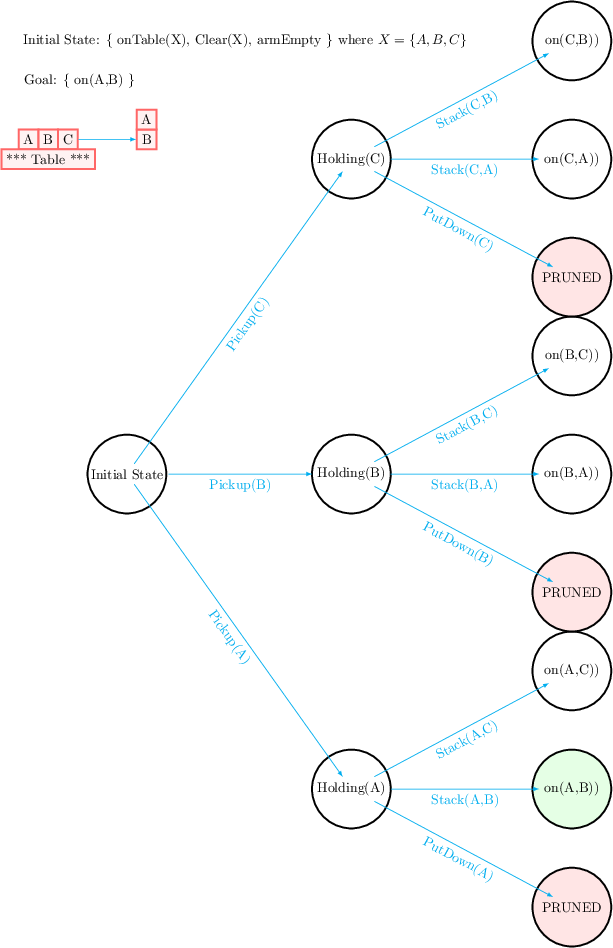

### Task. 2

Can you think of an initial situation where $\textit{IW}(1)$ cannot find a solution for the goal on(A,B), but $\textit{IW}(2)$ does, explain your answer?

iw2.png

# Help

## View the grounded representation of the blocksworld problem in propositional logic.

#### Four action model of Blocksworld

In [ ]:
#### Here we show the problem representation after parsing and grounding the
#### PDDL into propositional logic

print("###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######\n")

print("Size of operator set:", four_action_blocks_problem.num_actions())
print("Size of set of fluents:", four_action_blocks_problem.num_atoms())



four_action_blocks_problem.print_actions()
# Print action list
with open("actions.list", 'r') as file:
  print(file.read())

four_action_blocks_problem.print_fluents()
# Print fluent list
with open("fluents.list", 'r') as file:
  print(file.read())

###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######

Size of operator set: 24
Size of set of fluents: 19
Actions
Action (pick-up a)
	Pre(a) = {clear(a), ontable(a), handempty()}
	Add(a) = {holding(a)}
	Del(a) = {ontable(a), clear(a), handempty()}
	eDel(a) = {ontable(a), clear(a), handempty()}
	Conditional Effects:
Cost = 1
Action (pick-up b)
	Pre(a) = {clear(b), ontable(b), handempty()}
	Add(a) = {holding(b)}
	Del(a) = {ontable(b), clear(b), handempty()}
	eDel(a) = {ontable(b), clear(b), handempty()}
	Conditional Effects:
Cost = 1
Action (pick-up c)
	Pre(a) = {clear(c), ontable(c), handempty()}
	Add(a) = {holding(c)}
	Del(a) = {ontable(c), clear(c), handempty()}
	eDel(a) = {ontable(c), clear(c), handempty()}
	Conditional Effects:
Cost = 1
Action (put-down a)
	Pre(a) = {holding(a)}
	Add(a) = {clear(a), handempty(), ontable(a)}
	Del(a) = {holding(a)}
	eDel(a) = {holding(a)}
	Conditional Effects:
Cost = 1
Action (put-down b)
	Pre(a) = {holding(b)}
	Add(a) = {clear(b), handempty(), 

#### Two action model of Blocksworld


In [ ]:
#### Here we show the problem representation after parsing and grounding the
#### PDDL into propositional logic

print("###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######\n")

print("Size of operator set:", two_action_blocks_problem.num_actions())
print("Size of set of fluents:", two_action_blocks_problem.num_atoms(), "\n")

two_action_blocks_problem.print_actions()
# Print action list
print("# ---- #\nAction Set:\n")
with open("actions.list", 'r') as file:
  print(file.read())

two_action_blocks_problem.print_fluents()
# Print fluent list
print("# ---- #\nFluent Set:\n")
with open("fluents.list", 'r') as file:
  print(file.read())

###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######

Size of operator set: 18
Size of set of fluents: 15 

# ---- #
Action Set:

Actions
Action (move-to-block a a)
	Pre(a) = {clear(a), ontable(a), clear(a)}
	Add(a) = {on(a,a)}
	Del(a) = {ontable(a), clear(a)}
	eDel(a) = {ontable(a), clear(a)}
	Conditional Effects:
Cost = 1
Action (move-to-block a b)
	Pre(a) = {clear(a), ontable(a), clear(b)}
	Add(a) = {on(a,b)}
	Del(a) = {ontable(a), clear(b)}
	eDel(a) = {ontable(a), clear(b)}
	Conditional Effects:
Cost = 1
Action (move-to-block a c)
	Pre(a) = {clear(a), ontable(a), clear(c)}
	Add(a) = {on(a,c)}
	Del(a) = {ontable(a), clear(c)}
	eDel(a) = {ontable(a), clear(c)}
	Conditional Effects:
Cost = 1
Action (move-to-block b a)
	Pre(a) = {clear(b), ontable(b), clear(a)}
	Add(a) = {on(b,a)}
	Del(a) = {ontable(b), clear(a)}
	eDel(a) = {ontable(b), clear(a)}
	Conditional Effects:
Cost = 1
Action (move-to-block b b)
	Pre(a) = {clear(b), ontable(b), clear(b)}
	Add(a) = {on(b,b)}
	Del(a) = {ont

## View set of supporting actions for each fluent

In [ ]:
#HINT

print("Set of supporters for each fluent:")
supporting_actions = dict()
H_Add(four_action_blocks_problem).fetch_supporting_actions(supporting_actions)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

for k in supporting_actions.keys():
  print(k,":")
  for v in supporting_actions[k]:
    print("\t",v)

Set of supporters for each fluent:


<IPython.core.display.Javascript object>

clear(a) :
	 (put-down a)
	 (stack a a)
	 (stack a b)
	 (stack a c)
	 (unstack a a)
	 (unstack b a)
	 (unstack c a)
clear(b) :
	 (put-down b)
	 (stack b a)
	 (stack b b)
	 (stack b c)
	 (unstack a b)
	 (unstack b b)
	 (unstack c b)
clear(c) :
	 (put-down c)
	 (stack c a)
	 (stack c b)
	 (stack c c)
	 (unstack a c)
	 (unstack b c)
	 (unstack c c)
handempty() :
	 (put-down a)
	 (put-down b)
	 (put-down c)
	 (stack a a)
	 (stack a b)
	 (stack a c)
	 (stack b a)
	 (stack b b)
	 (stack b c)
	 (stack c a)
	 (stack c b)
	 (stack c c)
holding(a) :
	 (pick-up a)
	 (unstack a a)
	 (unstack a b)
	 (unstack a c)
holding(b) :
	 (pick-up b)
	 (unstack b a)
	 (unstack b b)
	 (unstack b c)
holding(c) :
	 (pick-up c)
	 (unstack c a)
	 (unstack c b)
	 (unstack c c)
on(a,a) :
	 (stack a a)
on(a,b) :
	 (stack a b)
on(a,c) :
	 (stack a c)
on(b,a) :
	 (stack b a)
on(b,b) :
	 (stack b b)
on(b,c) :
	 (stack b c)
on(c,a) :
	 (stack c a)
on(c,b) :
	 (stack c b)
on(c,c) :
	 (stack c c)
ontable(a) :
	 (put-down a